In [1]:
# Import the python librarys
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns; sns.set()
import gzip
import os

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# read meta data
kegg_orgs = pd.read_csv('Kegg_ko_org_matrix_cols_index.txt', sep='\t', header=-1, names=['id', 'name', 'tree', 'tax_id'])
kegg_kos = pd.read_csv('Kegg_ko_org_matrix_rows_index.txt', sep='\t', header=-1, names=['id', 'desc'])

kegg_orgs[['taxa1','taxa2','taxa3','taxa4']]=pd.DataFrame(kegg_orgs.tree.str.split(';',3).tolist(), columns = ['taxa1','taxa2','taxa3','taxa4'])
kegg_orgs['taxa12'] = kegg_orgs[['taxa1', 'taxa2']].apply(lambda x: ';'.join(x), axis=1)
kegg_orgs['taxa123'] = kegg_orgs[['taxa12', 'taxa3']].apply(lambda x: ';'.join(x), axis=1)
kegg_orgs[kegg_orgs['taxa1']=='Eukaryotes'].shape

(356, 10)

In [3]:
print('KEGG Organisms',kegg_orgs.shape)
print('KEGG Orthology',kegg_kos.shape)

KEGG Organisms (4648, 10)
KEGG Orthology (20624, 2)


In [4]:
# read matrix (from csv)
# Kegg_ko_org_matrix is huge to upload into GitHub.
# So please refer to the tutorial about how to generate this file,
# if you want to run this without any exception. 
data = []
with open('Kegg_ko_org_matrix.txt', 'r') as f:
    s = f.read()
    t = s.split('\n')
    for temp in t:
        data.append(list(temp))
kegg_ko_org_mat = np.array(data, dtype=np.uint8)

In [5]:
kegg_orgs[kegg_orgs['id'] == 'mbv']
np.sum(kegg_ko_org_mat[2501,:])

55

In [6]:
print('Matrix', kegg_ko_org_mat.shape)
int(kegg_ko_org_mat.shape[0]/64) + 1

Matrix (20624, 4648)


323

(4648,)


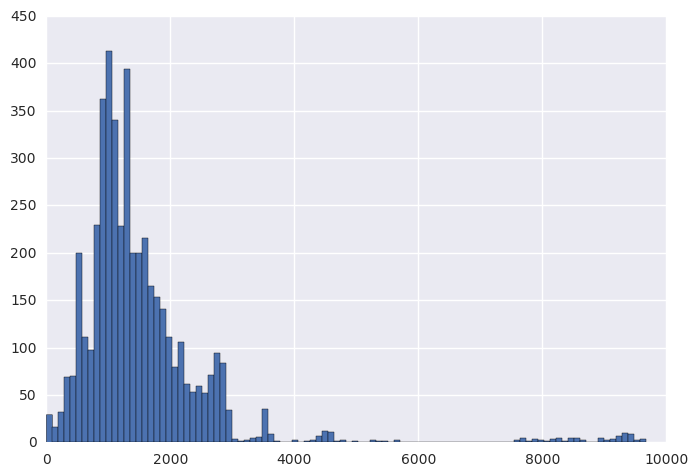

In [7]:
stat = np.sum(kegg_ko_org_mat, axis=0)
print(stat.shape)
plt.close('all')
f, ax = plt.subplots()
ax.hist(stat, 100, histtype='bar')
plt.show()

In [8]:
# small_orgs = kegg_orgs.iloc[(stat>200) & (stat<=600)].id.tolist()
small_orgs = kegg_orgs.iloc[(stat>200) & (stat<=600)][kegg_orgs['taxa2'] == 'Bacteria'].id.tolist()
len(small_orgs)

/Users/leej324/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


393

In [9]:
# read matrix (from gz)
def readGzip(filename):
    input_file = gzip.open(filename, 'rb')
    try:
        nrows = int.from_bytes(input_file.read(4), byteorder='little')
        ncols = int.from_bytes(input_file.read(4), byteorder='little')
        dt = np.dtype(np.uint64)
        dt = dt.newbyteorder('L')
        print('uint64_mat size:', nrows, ncols)
        t = np.frombuffer(input_file.read(), dtype=np.uint64).reshape((nrows, ncols))
    finally:
        input_file.close()
    return nrows, ncols, t

ncols, nrows, kegg_org_mat = readGzip('Kegg_ko_org_matrix.bin.gz')

# verify this is same or not to the original matrix
# uint64_mat.tobytes() == kegg_org_mat.tobytes()

uint64_mat size: 4648 323


In [10]:
print(np.binary_repr(kegg_org_mat[0,0]).split())
np.count_nonzero(np.binary_repr(kegg_org_mat[0,0]).split("\s"))

['1001000011100110000100001000010100101000011001100011000001001100']


1

In [11]:
# read a result table (binary file)
with open("/Users/leej324/Documents/projects/bsf-kegg/bin_4648_0_0_4648_4648_result_kegg.txt.bin", "rb") as f:
    rst_mat = np.frombuffer(f.read(), dtype=np.uint32).reshape((ncols, ncols))
rst_mat

array([[   0,  817,  787, ...,  846,  356,  387],
       [   0,    0,  689, ...,  702,  313,  320],
       [   0,    0,    0, ...,  667,  286,  323],
       ..., 
       [   0,    0,    0, ...,    0,  333,  359],
       [   0,    0,    0, ...,    0,    0, 2362],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint32)

In [12]:
sym_mat = np.zeros((ncols, ncols))
for i in range(ncols):
    for j in range(ncols):
        if i < j:
            sym_mat[i,j] = rst_mat[i,j]
        elif i > j:
            sym_mat[i,j] = rst_mat[j,i]

In [13]:
## correction!!
# we need to eliminate the all 0 columns (organisms having no KO)
nKos = np.sum(kegg_ko_org_mat, axis=0)
deleteIndex = np.where(nKos==0)
mat = np.delete(sym_mat, deleteIndex, 0)
mat = np.delete(mat, deleteIndex, 1)
norgs = mat.shape[0]

_kegg_orgs = kegg_orgs.drop(kegg_orgs.index[deleteIndex])
fixed_kegg_orgs = _kegg_orgs.reset_index(drop=True)

In [14]:
tuples = list(zip(np.array(fixed_kegg_orgs[['taxa1']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa2']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa3']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa4']]).flatten(),
                  np.array(fixed_kegg_orgs[['name']]).flatten(),
                  np.array(fixed_kegg_orgs[['id']]).flatten()))

m_index = pd.MultiIndex.from_tuples(tuples, names=['Lv1', 'Lv2', 'Lv3', 'Lv4', 'name', 'id'])
bigtable = pd.DataFrame(mat, index=m_index, columns=m_index)

In [15]:
# delete these
# Gammaproteobacteria-Unclassified mealybug symbionts
# Gammaproteobacteria-Unclassified aphid symbionts
small_orgs.remove('senm')
small_orgs.remove('sehc')

smalltb = bigtable.loc[bigtable.index.get_level_values('id').isin(small_orgs),bigtable.columns.get_level_values('id').isin(small_orgs)]

/Users/leej324/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.


In [ ]:
smalltb.to_csv('small_genomes.txt', sep='\t')

In [19]:
colormap=plt.get_cmap('Paired')
def drawHeatmapMatrix(table, index_level, filename = 'heatmap.png', cmap = colormap, vmin=None, vmax=None, figsize=(30, 30)):
    plt.close("all")
    
    sns.set(style="white")

    # Create a custom palette to identify the networks
    groups = np.unique(table.index.get_level_values(index_level))
    t_pal = sns.diverging_palette(240, 10, n=len(groups))
    t_lut = dict(zip(map(str, groups), t_pal))
    # Convert the palette to vectors that will be drawn on the side of the matrix
    t_colors = pd.Series(table.index.get_level_values(index_level), index=table.columns).map(t_lut)
    # Draw the full plot
    cg = sns.clustermap(table, row_colors=t_colors, linewidths=0.1, row_cluster=False,col_cluster=False, 
                   col_colors=t_colors, figsize=figsize, cmap=cmap, vmin=vmin, vmax=vmax)
    
    ## customize the labels
    labels = [item.get_text() for item in cg.ax_heatmap.get_yticklabels()]
    total = 0
    for i in range(len(labels)):
        label = labels[i]
        labels[i] = label.split('-',1)[1]
        lv4 = labels[i].rsplit('-', 1)[1]
        nrows, ncols = smalltb.loc[smalltb.index.get_level_values('Lv4')==lv4].shape
        total += nrows
        labels[i] = labels[i] + '(' + str(nrows) + ')'
        labels[i] = labels[i].replace('Enterobacteria-', '')
        labels[i] = labels[i].replace('Others-', '')
        labels[i] = labels[i].replace(' - ', '-')
        labels[i] = labels[i].replace('Unclassified Bathyarchaeota', 'Unclassified')
        labels[i] = labels[i].replace('Unclassified Gammaproteobacteria', 'Unclassified')
        labels[i] = labels[i].replace('Unclassified Clostridiales', 'Unclassified')
        labels[i] = labels[i].replace('Unclassified Deltaproteobacteria', 'Unclassified')
        labels[i] = labels[i].replace('Unclassified Nanohaloarchaea', 'Unclassified')
        labels[i] = labels[i].replace('Unclassified Flavobacteriia', 'Unclassified')
        print(labels[i])

    cg.ax_heatmap.set_yticklabels(labels)
    labels.reverse()
    cg.ax_heatmap.set_xticklabels(labels)
    
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    
    cg.ax_heatmap.xaxis.set_label_text('')
    cg.ax_heatmap.yaxis.set_label_text('')
    
    ilist, ilist = np.where(np.isnan(cg.data2d))
    offset = 39
    for i in ilist:
        cg.ax_heatmap.add_patch(matplotlib.patches.Rectangle((i+0.1,offset-i+0.1),0.8,0.8, fill=False))
        cg.ax_heatmap.plot([i+0.1,i+0.9], [offset-i+0.1,offset-i+0.9], '-', lw=.5, color = '0.75')
        cg.ax_heatmap.plot([i+0.9,i+0.1], [offset-i+0.1,offset-i+0.9], '-', lw=.5, color = '0.75')

#     cg.savefig(filename)
    cg.savefig(filename, format='eps', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cg

Verrucomicrobia-Xiphinematobacter(1)
Tenericutes-Ureaplasma(4)
Tenericutes-Spiroplasma(17)
Tenericutes-Phytoplasma(7)
Tenericutes-Mycoplasma(88)
Tenericutes-Mesoplasma(2)
Tenericutes-Hepatoplasma(1)
Spirochaetes-Treponema(12)
Spirochaetes-Borreliella(17)
Spirochaetes-Borrelia(9)
Other-Saccharibacteria(4)
Gammaproteobacteria-Unclassified(2)
Gammaproteobacteria-Portiera(9)
Gammaproteobacteria-Evansia(1)
Gammaproteobacteria-Coxiella(1)
Gammaproteobacteria-Unclassified Enterobacteria(5)
Gammaproteobacteria-Riesia(1)
Gammaproteobacteria-Moranella(2)
Gammaproteobacteria-Buchnera(17)
Gammaproteobacteria-Blochmannia(4)
Firmicutes-Clostridia-Unclassified(1)
Firmicutes-Bacilli-Lactobacillus(1)
Elusimicrobia-Termite group 1(1)
Deltaproteobacteria-Unclassified(1)
Chlamydiae-Chlamydia(113)
Betaproteobacteria-Zinderia(1)
Betaproteobacteria-Profftella(1)
Bacteroidetes-Uzinura(1)
Bacteroidetes-Unclassified(1)
Bacteroidetes-Sulcia(7)
Bacteroidetes-Cardinium(1)
Bacteroidetes-Blattabacterium(8)
Bacteroid

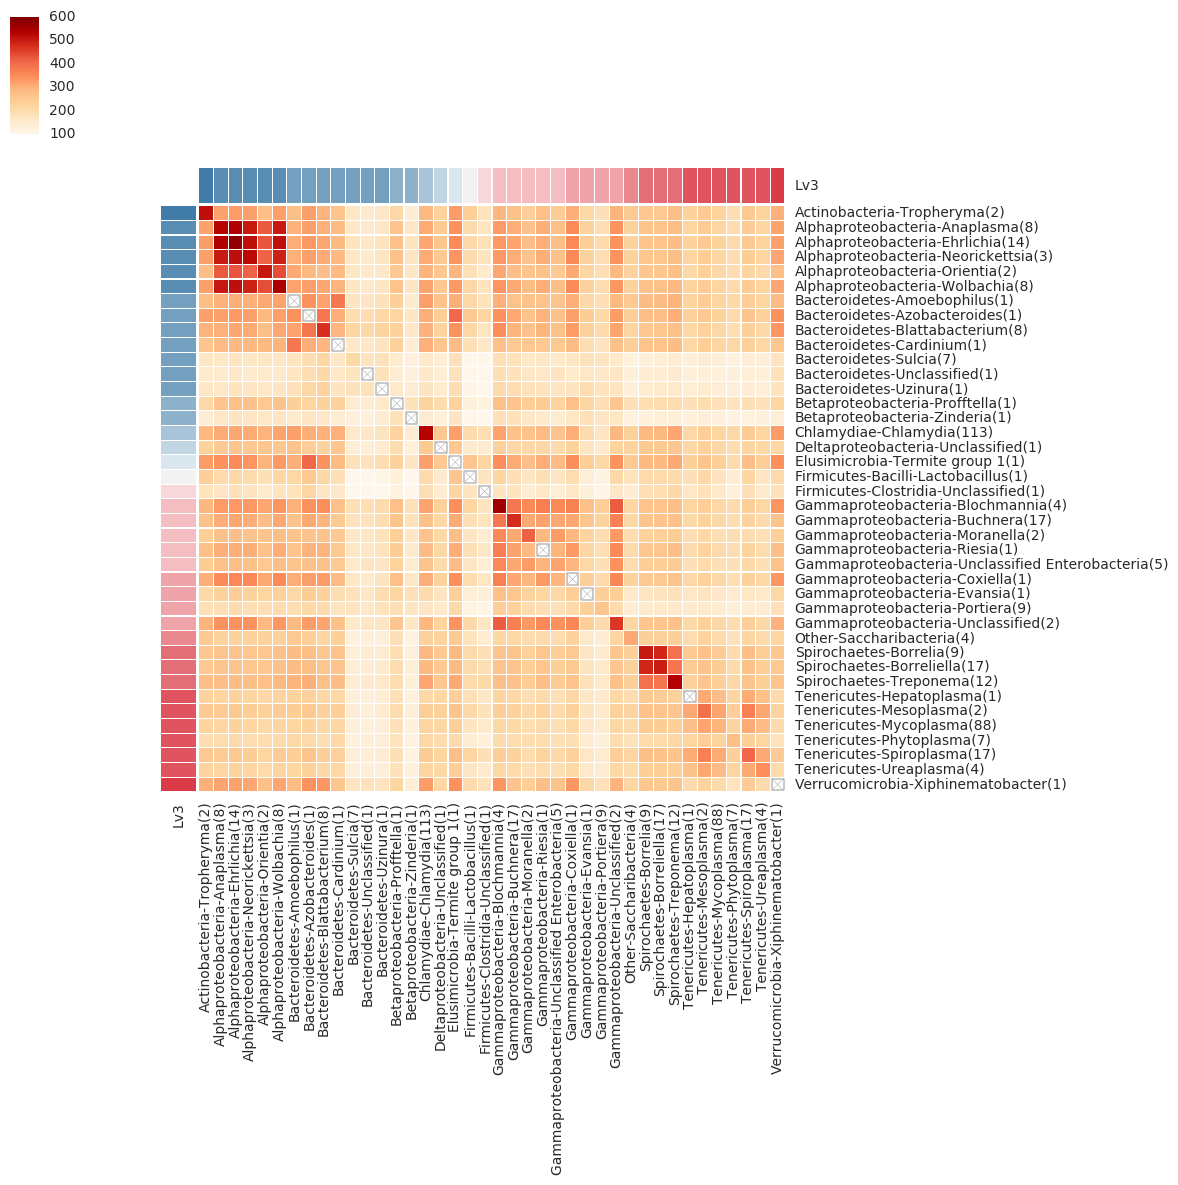

In [20]:
# to avoid the wrong calculation because of the diagonal terms
np.fill_diagonal(smalltb.values, np.nan)

grouped = smalltb.groupby(level=[1,2,3]).mean()
grouped = grouped.groupby(level=[1,2,3], axis=1).mean()

cg = drawHeatmapMatrix(grouped, 'Lv3', 'overall_heatmap_200_600.eps', plt.get_cmap('OrRd'),vmin=100, vmax=600, figsize=(10,10))